# Complete candidate search (nrw_2022, 1,250 sequences)
This notebook contains the evaluation of the complete candidate search concerning the aggregate nrw_2022 with 1,250 sequences. Breadth search and depth search results were taken into account.
The distance matrices were evaluated in terms of infection recall. Furthermore, the mst structure was evaluated based on community ARI, lineage purity and mean edge weight. MSTs were generated to compare the results with the MST of the optimized algorithm regarding the distribution of outbreak-related attributes.

In [1]:
!pip install ../../gentrain/.

Processing /Users/benkraling/code/thesis/gentrain
  Preparing metadata (setup.py) ... done
  Created wheel for gentrain: filename=gentrain-0.1.2-py3-none-any.whl size=26677 sha256=b676ce951cfd4542a5c7ae27b9aefcf825a15baf0e39696df76b54a13fe2f034
  Stored in directory: /private/var/folders/2h/923cq6912sqb0snfvqqfdnmm0000gn/T/pip-ephem-wheel-cache-nia4ygq3/wheels/cf/e4/57/91c03db2e8c043adeefe35dd0969d3049f61ae0218be0acc9f
Successfully built gentrain
  Attempting uninstall: gentrain
    Found existing installation: gentrain 0.1.2
    Uninstalling gentrain-0.1.2:
      Successfully uninstalled gentrain-0.1.2


In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
from gentrain.evaluation import get_computation_rate_plot, candidate_evaluation_and_matrices, get_candidate_evaluation_and_export_mst
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from gentrain.encoding import get_nucleotide_sensitive_encodings, get_mutation_sensitive_encodings, generate_one_hot_encoding
from gentrain.nextclade import get_mutations_from_dataframe
from gentrain.candidate_sourcing import bitwise_xor_candidates
from gentrain.graph import build_mst, export_graph_gexf, mean_edge_weight, get_outbreak_community_labels, build_graph
from scipy.spatial.distance import pdist
import community as community_louvain
import umap
import faiss
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin
import os
import shutil

In [3]:
aggregate = "nrw_2022"
size = 1250

In [4]:
graph_path = f"graphs/{aggregate}/{size}"
if os.path.exists(f"graphs/{aggregate}/{size}") and os.path.isdir(f"graphs/{aggregate}/{size}"):
    shutil.rmtree(f"graphs/{aggregate}/{size}")
if not os.path.exists(f"graphs/{aggregate}"):
    os.mkdir(f"graphs/{aggregate}")
os.mkdir(f"graphs/{aggregate}/{size}")

In [5]:
sequences_df = pd.read_csv(f"../00_data_understanding_and_preparation/aggregates/{aggregate}/{size}/sequences_and_metadata.csv", delimiter=";").set_index("igs_id").sort_index()
sequences_count = len(sequences_df)

In [6]:
mutations_df = get_mutations_from_dataframe(sequences_df)

In [7]:
distance_matrix_df = pd.read_csv(f"../01_algorithm_optimization/distance_matrices/{aggregate}/{size}/distance_matrix.csv", delimiter=";",
                                     index_col="Unnamed: 0").sort_index()
distance_matrix_df = distance_matrix_df[~distance_matrix_df.index.duplicated(keep="first")]
distance_matrix_df = distance_matrix_df.loc[sequences_df.index, sequences_df.index]
distance_matrix = distance_matrix_df.to_numpy()

In [8]:
gentrain_graph = build_graph(distance_matrix)
gentrain_mst = build_mst(gentrain_graph)
gentrain_community_labels = get_outbreak_community_labels(gentrain_mst)
datetime_sampling_dates = pd.to_datetime(sequences_df["date_of_sampling"])
numeric_dates = (datetime_sampling_dates - datetime_sampling_dates.min()).dt.days
export_graph_gexf(gentrain_mst, gentrain_community_labels, sequences_df, f"{graph_path}/brute_force")

mst generation time: 1.91s


In [9]:
mask = np.triu(np.ones(distance_matrix_df.shape), k=1).astype(bool)
filtered = distance_matrix_df.where(mask)
infections_count = (filtered < 2).sum().sum()
distances_count = filtered.count().sum()

In [10]:
encodings_N_frequency_filter = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=False, filter_N=True)

execution time: 26.95s


### Depth search with N frequency filter

In [11]:
depth_search_N_frequency_filter = []
for computation_rate in [0.05, 0.1, 0.15, 0.2]:
    limit = int(computation_rate*distances_count)
    candidates, runtime = bitwise_xor_candidates(encodings_N_frequency_filter, limit, "depth")
    depth_search_N_frequency_filter.append(get_candidate_evaluation_and_export_mst("depth_N", candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime))

execution time xor distance calculation: 2.79s
execution time depth search: 0.44s
execution time 39031: 3.34s
mst generation time: 0.05s
execution time xor distance calculation: 2.88s
execution time depth search: 0.49s
execution time 78062: 3.47s
mst generation time: 0.19s
execution time xor distance calculation: 3.53s
execution time depth search: 0.54s
execution time 117093: 4.18s
mst generation time: 0.43s
execution time xor distance calculation: 2.54s
execution time depth search: 0.54s
execution time 156125: 3.17s
mst generation time: 0.48s


In [12]:
pd.DataFrame(depth_search_N_frequency_filter)

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
0,0.050000,0.944238,1.0,1.0,0.944238,3.34,3.818716,-0.479763,14.0,144,0.501166,0.975698,0.023698
1,0.099999,0.983271,1.0,1.0,0.983271,3.47,4.044482,-0.253997,15.0,63,0.612745,0.973109,0.021109
2,0.149999,0.996283,1.0,1.0,0.996283,4.18,4.134593,-0.163886,18.0,33,0.734795,0.971335,0.019335
3,0.200000,0.998141,1.0,1.0,0.998141,3.17,4.125756,-0.172722,16.0,27,0.806087,0.971452,0.019452


### Breadth search with N frequency filter

In [13]:
breadth_search_N_frequency_filter = []
for computation_rate in [0.05, 0.1, 0.15, 0.2]:
    limit = int(computation_rate*distances_count)
    candidates, runtime = bitwise_xor_candidates(encodings_N_frequency_filter, limit, "breadth")
    breadth_search_N_frequency_filter.append(get_candidate_evaluation_and_export_mst("breadth_N", candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime))

matrix generation time: 1.78s
execution time distance collection: 0.76s
execution time breadth search: 0.69s
execution time 39031: 3.34s
mst generation time: 0.05s
matrix generation time: 1.62s
execution time distance collection: 0.68s
execution time breadth search: 0.66s
execution time 78062: 3.06s
mst generation time: 0.18s
matrix generation time: 1.64s
execution time distance collection: 0.67s
execution time breadth search: 0.67s
execution time 117093: 3.08s
mst generation time: 0.25s
matrix generation time: 1.58s
execution time distance collection: 0.66s
execution time breadth search: 0.66s
execution time 156125: 3.01s
mst generation time: 0.32s


In [14]:
pd.DataFrame(breadth_search_N_frequency_filter)

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
0,0.050565,0.791822,1.0,1.0,0.791822,3.34,4.503843,0.205364,34.0,1,0.428393,0.9600,0.0080
1,0.098298,0.905204,1.0,1.0,0.905204,3.06,4.419215,0.120737,34.0,1,0.514182,0.9440,-0.0080
2,0.144801,0.936803,1.0,1.0,0.936803,3.08,4.377742,0.079263,34.0,1,0.568707,0.9568,0.0048
3,0.190072,0.953532,1.0,1.0,0.953532,3.01,4.363331,0.064852,34.0,1,0.607314,0.9472,-0.0048


### Depth search with N and SNV frequency filter

In [15]:
encodings_N_and_SNV_frequency_filter = get_mutation_sensitive_encodings(sequences_df, exclude_indels=False, use_frequency_filtering=True, filter_N=True)

execution time: 28.24s


In [16]:
depth_search_N_and_SNV_frequency_filter = []
for computation_rate in [0.05, 0.1, 0.15, 0.2]:
    limit = int(computation_rate*distances_count)
    candidates, runtime = bitwise_xor_candidates(encodings_N_and_SNV_frequency_filter, limit, "depth")
    depth_search_N_and_SNV_frequency_filter.append(get_candidate_evaluation_and_export_mst("depth_N_and_SNV", candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime))

execution time xor distance calculation: 1.55s
execution time depth search: 0.47s
execution time 39031: 2.12s
mst generation time: 0.05s
execution time xor distance calculation: 1.53s
execution time depth search: 0.48s
execution time 78062: 2.1s
mst generation time: 0.19s
execution time xor distance calculation: 1.64s
execution time depth search: 0.49s
execution time 117093: 2.23s
mst generation time: 0.26s
execution time xor distance calculation: 1.39s
execution time depth search: 0.47s
execution time 156125: 1.95s
mst generation time: 0.37s


In [17]:
pd.DataFrame(depth_search_N_and_SNV_frequency_filter)

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
0,0.050000,0.918216,1.0,1.0,0.918216,2.12,3.965818,-0.332661,28.0,150,0.476577,0.986679,0.034679
1,0.099999,0.970260,1.0,1.0,0.970260,2.10,4.018462,-0.280017,28.0,80,0.701398,0.967905,0.015905
2,0.149999,0.986989,1.0,1.0,0.986989,2.23,4.136190,-0.162289,28.0,48,0.758047,0.965289,0.013289
3,0.200000,0.992565,1.0,1.0,0.992565,1.95,4.177239,-0.121240,23.0,33,0.785740,0.965630,0.013630


### Breadth search with N and SNV frequency filter

In [19]:
breadth_search_N_and_SNV_frequency_filter = []
for computation_rate in [0.05, 0.1, 0.15, 0.2]:
    limit = int(computation_rate*distances_count)
    candidates, runtime = bitwise_xor_candidates(encodings_N_and_SNV_frequency_filter, limit, "breadth")
    breadth_search_N_and_SNV_frequency_filter.append(get_candidate_evaluation_and_export_mst("breadth_N_and_SNV", candidates, graph_path, distance_matrix, gentrain_community_labels, gentrain_mst, list(sequences_df["clade"]), sequences_df, runtime))

matrix generation time: 0.72s
execution time distance collection: 0.7s
execution time breadth search: 0.64s
execution time 39031: 2.17s
mst generation time: 0.05s
matrix generation time: 0.75s
execution time distance collection: 0.68s
execution time breadth search: 0.63s
execution time 78062: 2.15s
mst generation time: 0.18s
matrix generation time: 0.76s
execution time distance collection: 0.68s
execution time breadth search: 0.63s
execution time 117093: 2.17s
mst generation time: 0.25s
matrix generation time: 0.79s
execution time distance collection: 0.66s
execution time breadth search: 0.63s
execution time 156125: 2.17s
mst generation time: 0.35s


In [20]:
pd.DataFrame(breadth_search_N_and_SNV_frequency_filter)

,computation_rate,infection_detection_rate,infection_recall,infection_precision,infection_f1,runtime,mean_edge_weight,mean_edge_weight_diff,max_edge_weight,subgraph_count,adjusted_rand_index,lineage_purity,lineage_purity_diff
0,0.050565,0.767658,1.0,1.0,0.767658,2.17,4.503443,0.204964,34.0,1,0.472196,0.9496,-0.0024
1,0.098298,0.894052,1.0,1.0,0.894052,2.15,4.428743,0.130264,34.0,1,0.549463,0.9464,-0.0056
2,0.144801,0.929368,1.0,1.0,0.929368,2.17,4.400080,0.101601,34.0,1,0.617092,0.9456,-0.0064
3,0.190072,0.936803,1.0,1.0,0.936803,2.17,4.379263,0.080785,34.0,1,0.768933,0.9480,-0.0040


In [21]:
depth_search_evaluation = {
    "N frequency filter": {"values": {evaluation["computation_rate"]: evaluation for evaluation in depth_search_N_frequency_filter}, "stroke": "dash", "color": "black"},
    "N & SNV frequency filter": {"values": {evaluation["computation_rate"]: evaluation for evaluation in depth_search_N_and_SNV_frequency_filter}, "stroke": "dot", "color": "black"}
}

In [22]:
breadth_search_evaluation = {
    "N frequency filter": {"values": {evaluation["computation_rate"]: evaluation for evaluation in breadth_search_N_frequency_filter}, "stroke": "dash", "color": "black"},
    "N & SNV frequency filter": {"values": {evaluation["computation_rate"]: evaluation for evaluation in breadth_search_N_and_SNV_frequency_filter}, "stroke": "dot", "color": "black"}
}

### Infection recall for different filters and computation rates using depth search

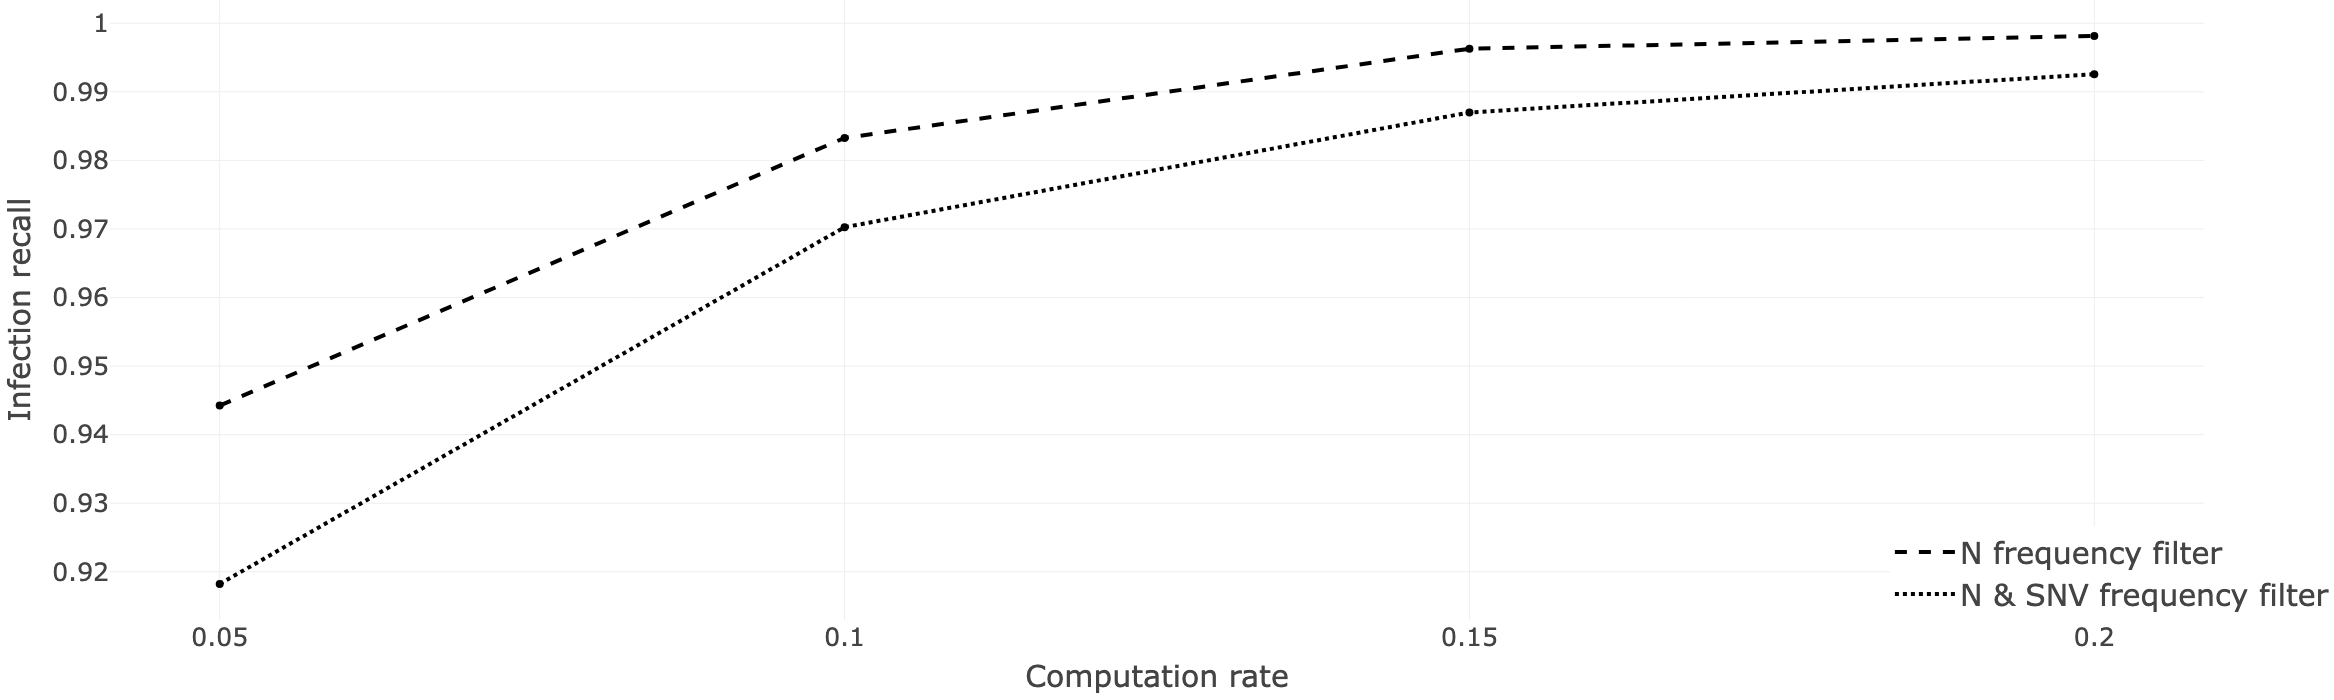

In [23]:
sub_fig = get_computation_rate_plot("infection_detection_rate", depth_search_evaluation, "Infection recall", dict(
            x=0.85,
            y=0,
            itemwidth=60,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=30),
        ))

sub_fig.show()

### Community ARI for different filters and computation rates using depth search

In [24]:
sub_fig = get_computation_rate_plot("adjusted_rand_index", depth_search_evaluation, "Community ARI", dict(
            x=0.85,
            y=0,
            itemwidth=60,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=30),
        ))

sub_fig.show()

### Infection recall for different filters and computation rates using breadth search

In [25]:
sub_fig = get_computation_rate_plot("infection_detection_rate", breadth_search_evaluation, "Infection recall", legend=dict(
            x=0.65,
            y=0.05,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=35),
        ))
sub_fig.show()

### Community ARI for different filters and computation rates using breadth search

In [26]:
sub_fig = get_computation_rate_plot("adjusted_rand_index", breadth_search_evaluation, "Community ARI", legend=dict(
            x=0.55,
            y=0.02,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=35),
        ))
sub_fig.show()

In [27]:
depth_vs_breadth_search_evaluation = {
    "Depth search": {"values": {evaluation["computation_rate"]: evaluation for evaluation in depth_search_N_and_SNV_frequency_filter}, "stroke": "solid", "color": "blue"},
    "Breadth search": {"values": {evaluation["computation_rate"]: evaluation for evaluation in breadth_search_N_and_SNV_frequency_filter}, "stroke": "solid", "color": "green"},  
}

### Infection recall for different computation rates using depth search and breadth search (N and SNV frequency filter)

In [28]:
sub_fig = get_computation_rate_plot("infection_detection_rate", depth_vs_breadth_search_evaluation, "Infection recall", legend=dict(
            x=0.7,
            y=0.1,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=35),
        ))
sub_fig.show()

### Community ARI for different computation rates using depth search and breadth search (N and SNV frequency filter)

In [29]:
sub_fig = get_computation_rate_plot("adjusted_rand_index", depth_vs_breadth_search_evaluation, "Community ARI", legend=dict(
            x=0.7,
            y=0.1,
            xanchor="left",
            yanchor="bottom",
            font=dict(size=35),
        ))
sub_fig.show()